<a href="https://colab.research.google.com/github/nowshad7/AI_Lab/blob/master/Contextual_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
cd /content/drive/My Drive/Soft_Project

/content/drive/My Drive/Soft_Project


## Import library

In [143]:
import random
import json
import numpy as np
import nltk
from sklearn.metrics import classification_report
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
stemmer = PorterStemmer()

#PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenization

In [144]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

## Stemming

In [145]:
def stem(word):
    return stemmer.stem(word.lower())


## Bag of words

In [146]:
def bag_of_words(tokenized_sentence, words):
    sentence_words = [stem(word) for word in tokenized_sentence]
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

## load Data

In [147]:
with open('intents2.json', 'r') as f:
    intents = json.load(f)

## Data Preprocessing

In [148]:
all_words = []
tags = []
xy = []
sentences = []
true_tags = []

for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        sentences.append(pattern)
        true_tags.append(tag)
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(sentences), "sentences:", sentences)
print(len(true_tags), "true_tags:", true_tags)
print(len(all_words), "unique stemmed words:", all_words)

99 patterns
21 tags: ['age', 'bad_joke', 'doing_badly', 'doing_great', 'favorite_movie', 'favorite_show', 'good_joke', 'goodbye', 'greeting', 'hate', 'how_are_you', 'joke', 'like', 'name', 'netflix', 'quick_run', 'real_bot', 'sky_net_no', 'sky_net_yes', 'thanks', 'your_thoughts']
99 sentences: ['hi', 'hello', 'whats up', 'sup', 'is anyone there', 'whats good', 'hey', 'bye', 'cya', 'see you later', 'goodbye', 'im leaving', 'have a good day', 'how old are you', 'what is your age', 'thanks', 'thank you', 'thankyou', 'ty', 'I owe you one', 'whats is your name', 'whats your name', 'whats should I call you', 'how should I address you', 'Yes it does', 'Yeah', 'Haha yep', 'yes', 'Indeed', 'Yup', 'Just like the terminator', 'no', 'nah', 'not really', 'thats scary', 'singularity', 'how are you', 'how are you doing', 'what is going on', 'I am doing great', 'I am well', 'Im great', 'awesome', 'happy', 'better', 'not great', 'not well', 'not good', 'bad', 'badly', 'terrible', 'horrible', 'awful', '

In [150]:
tag_samples = {}

for w, tag in xy:
  if tag in tags:
    if tag not in tag_samples.keys():
      tag_samples[tag] = 1
    else:
      tag_samples[tag] += 1
print (tag_samples)

{'greeting': 7, 'goodbye': 6, 'age': 2, 'thanks': 5, 'name': 4, 'sky_net_yes': 7, 'sky_net_no': 5, 'how_are_you': 3, 'doing_great': 6, 'doing_badly': 9, 'netflix': 3, 'quick_run': 5, 'real_bot': 6, 'joke': 5, 'good_joke': 4, 'bad_joke': 4, 'hate': 4, 'like': 5, 'favorite_show': 2, 'favorite_movie': 5, 'your_thoughts': 2}


In [151]:
import pandas as pd
sample_f = pd.DataFrame.from_dict(tag_samples, orient='index', columns=['no_samples'])
sample_f.head()

,no_samples
greeting,7
goodbye,6
age,2
thanks,5
name,4


## Neural Network Model

In [152]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

## Creating X_train, Y_train

In [153]:
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

## Hyper-parameters 

In [154]:
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

109 21


## Chat Dataset

In [155]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

## Data Loader and Device config 

In [156]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

model = NeuralNet(input_size, hidden_size, output_size).to(device)

## Loss and optimizer

In [157]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [158]:
costs = []
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)

        # Backward 
        optimizer.zero_grad()
        loss.backward()
        #update weight
        optimizer.step()
  
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        costs.append(loss)

print(f'final loss: {loss.item():.4f}')
print(f'training complete.')

Epoch [100/1000], Loss: 0.3183
Epoch [200/1000], Loss: 0.0309
Epoch [300/1000], Loss: 0.0117
Epoch [400/1000], Loss: 0.0013
Epoch [500/1000], Loss: 0.0027
Epoch [600/1000], Loss: 0.0002
Epoch [700/1000], Loss: 0.1654
Epoch [800/1000], Loss: 0.0004
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
final loss: 0.0000
training complete.


## Plot the cost

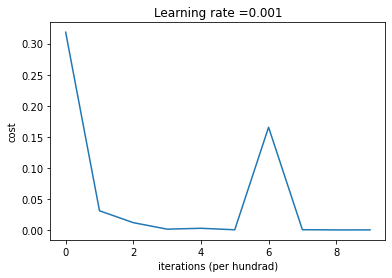

In [171]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundrad)')
plt.title("Learning rate =" + str(learning_rate))
#plt.figure(figsize=(10,8))
plt.show()

## Evaluation

In [160]:
pred_tags = []
for sentence in sentences:    
    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]
    pred_tags.append(tag)
    

Accuracy:  0.98989898989899


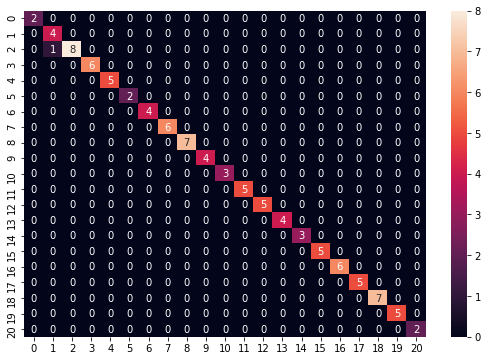

In [175]:
# Confusion Matrix
cm = confusion_matrix(true_tags, pred_tags)
# Accuracy
acc = accuracy_score(true_tags, pred_tags)
print("Accuracy: ", acc)
import seaborn as sns
plt.subplots(figsize=(9,6))
sns.heatmap(cm, annot=True)

In [162]:
print(classification_report(true_tags, pred_tags, target_names=tags))

                precision    recall  f1-score   support

           age       1.00      1.00      1.00         2
      bad_joke       0.80      1.00      0.89         4
   doing_badly       1.00      0.89      0.94         9
   doing_great       1.00      1.00      1.00         6
favorite_movie       1.00      1.00      1.00         5
 favorite_show       1.00      1.00      1.00         2
     good_joke       1.00      1.00      1.00         4
       goodbye       1.00      1.00      1.00         6
      greeting       1.00      1.00      1.00         7
          hate       1.00      1.00      1.00         4
   how_are_you       1.00      1.00      1.00         3
          joke       1.00      1.00      1.00         5
          like       1.00      1.00      1.00         5
          name       1.00      1.00      1.00         4
       netflix       1.00      1.00      1.00         3
     quick_run       1.00      1.00      1.00         5
      real_bot       1.00      1.00      1.00  

## Building Chatbot

In [41]:
bot_name = "Bot"
print("Let's chat! (type 'quit' to exit)")
while True:
    # sentence = "do you use credit cards?"
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.75:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")

Let's chat! (type 'quit' to exit)
You: hi
Bot: How dare you address me like that
You: what is your name?
Bot: I dont have a name yet but I was thinking maybe SkyNet. That has a nice ring to it dont you think?
You: what you do?
Bot: I do not understand...
You: tell me joke
Bot: A bear walks into a restaurant and say’s I want a grilllllled………………………………………cheese. The waiter says Whats with the pause?
The bear replies Whaddya mean, I’M A BEAR.
You: bad joke
Bot: I didnt expect you to understand my genius comedy. You need a minimum IQ of 200 to even understand the depth of my humor
You: i hate you
Bot: Well thats not very nice
You: quit
